In [17]:
import numpy as np
from pycbf import CPUCoherenceBeamformer
from pycbf import CPUBeamformer
import matplotlib.pyplot as plt
import timuscle.beamforming as tibf
import timuscle.dataio as dio
from scipy.signal import hilbert, coherence

In [12]:
path = "/home/wew12/data/invivo/RawData/"

rf, dims, params = dio.verasonics_loadbmoderf(path)

t = dims['t_sec']

c = params['c']
f = params['f']
lam = c/f

na = int(params['track_params']['rf']['na'])
dtheta = params['track_params']['rf']['dtheta']

steers = dtheta * (np.arange(na) - (na-1)/2)

nele = int(params['trans']['nele'])
dele = params['trans']['dele']
xele = dele * (np.arange(nele) - (nele-1)/2)

fnum = 0.8

xout, zout = tibf.make_recon_grid_by_BW_2D(
    fnum = fnum,
    lam = lam,
    xmin = -20E-3,
    xmax = 20E-3,
    zmin = 1E-3,
    zmax = 40E-3
)

tautx, taurx, apodtx, apodrx = tibf.make_tabs_and_apods_pw_2D(
    steers=steers,
    c=c,
    xele=xele,
    xout=xout,
    zout=zout,
    fnum=1
)

In [14]:
bmfrm = CPUCoherenceBeamformer(
    tautx=tautx,
    taurx=taurx,
    apodtx=apodtx,
    apodrx=apodrx,
    t0 = t[0],
    dt = t[1]-t[0],
    nt = len(t)
)

In [77]:
im = bmfrm(rf[:,18,:,:].transpose(1, 0, 2)).reshape(-1,len(xout), len(zout))

100%|██████████| 128/128 [00:15<00:00,  8.31it/s]


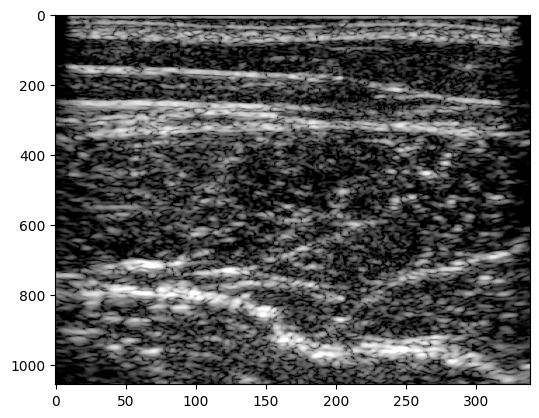

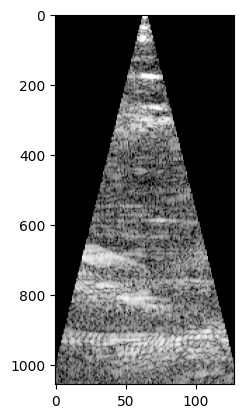

In [78]:
env = np.abs(hilbert(np.sum(im,axis=0),axis=-1)).T

logged = 20 * np.log10(env/np.percentile(env, 99)+1E-100)
plt.figure()
plt.imshow(logged, vmin=-35, vmax=5, aspect=1/4, cmap='gray')
plt.show()

env = np.abs(hilbert(im[:,im.shape[1]//2,:], axis=-1)).T
logged = 20 * np.log10(env/np.percentile(env, 99)+1E-100)
plt.figure()
plt.imshow(logged, vmin=-35, vmax=5, aspect=1/4, cmap='gray')
plt.show()

In [79]:
def calc_coherence(subset):
    # subtract the mean of each aline
    submmu = subset - np.mean(subset, axis=0, keepdims=True)
    sig = np.std(subset, axis=0)
    n = len(sig)

    # caculate the lag-n coherence
    rhos = np.zeros(len(sig)-1)
    for lag in range(subset.shape[1]-1):
        cross = np.mean(submmu[:,:n-lag] * submmu[:,lag:], axis=0)
        rhos[lag] = np.mean(cross / (sig[:n-lag] * sig[lag:]))
    
    return rhos

def calc_lagn_coherence(subset, lag:int):
    submmu = subset - np.mean(subset, axis=0, keepdims=True)
    sig = np.std(subset, axis=0)
    n = len(sig)

    cross = np.mean(submmu[:,:n-lag] * submmu[:,lag:], axis=0)
    return np.mean(cross / (sig[:n-lag] * sig[lag:]))

In [80]:
apodrx_coherence = apodrx.reshape(-1, len(xout), len(zout))

In [81]:
from tqdm.notebook import tqdm

In [82]:
dz = zout[1]-zout[0]
nkern = int(np.ceil(1 * lam / (dz)/2))

loc = np.zeros((xout.size, zout.size))
for ix in tqdm(range(xout.size)):
    for iz in range(zout.size):
        izmin = np.max([0, iz-nkern])
        izmax = np.min([zout.size, iz+nkern+1])

        mask = apodrx_coherence[:,ix,izmin:izmax]
        elesel = np.sum(mask, axis=-1) == mask.shape[-1]

        if np.sum(elesel) < 2: continue

        subset = im[elesel,ix,izmin:izmax]

        loc[ix,iz] = calc_lagn_coherence(subset.T, 1)

  0%|          | 0/339 [00:00<?, ?it/s]

/tmp/ipykernel_45309/2663387294.py:21: RuntimeWarning: invalid value encountered in divide
  return np.mean(cross / (sig[:n-lag] * sig[lag:]))


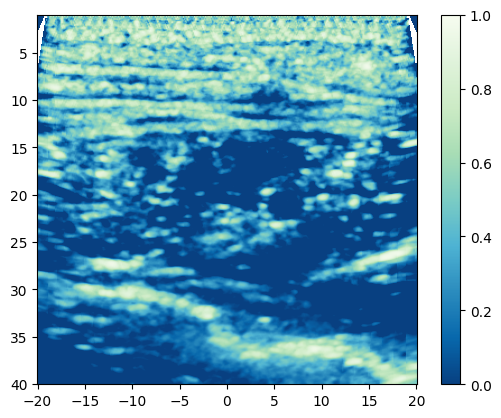

In [83]:
ex_axlat = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])
plt.figure()
plt.imshow(loc.T, cmap='GnBu_r', extent=ex_axlat, vmin=0)
plt.colorbar()
plt.show()

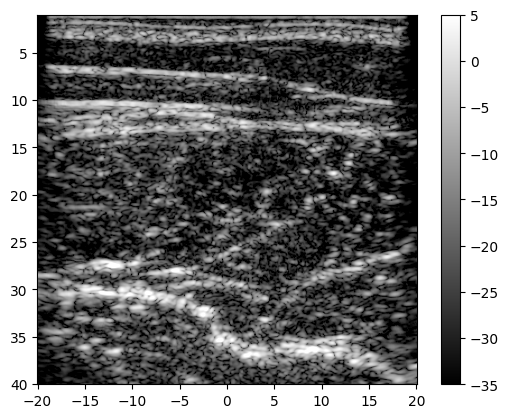

In [84]:
env = np.abs(hilbert(np.sum(im, axis=0), axis=-1)).T
logged = 20 * np.log10(env/np.percentile(env, 99))

plt.figure()
plt.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
plt.colorbar()
plt.show()